# Introduction

This notebook will provide further cleaning for all three datasets. Most sections end with exporting the dataset to a file for later use.

This notebook will combine the satellite chlorophyll data downloaded in [`ChesapeakeBaySatellite.ipynb`]('notebooks/APIs/ChesapeakeBaySatellite.ipynb') with the buoy based weather data from [`data/buoy_aggregate.csv`]('../../data/buoy_aggregate.csv') in order to use the data in our model. It will also prepare the [`data/water_cleaned.csv`]('../data/water_cleaned.csv') data for the model.

In [1]:
import pandas as pd
import numpy as np
import json
import xarray as xr
from scipy.interpolate import RBFInterpolator


import xarray as xr
import matplotlib.pyplot as plt

import logging
from tqdm import tqdm  # For progress bar
# Configure logging instead of print
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

import torch

We will read in the buoy data and water quality data from CSV. In both cases, we need to turn data and time columns into a datatime column numeric data. However, the columns are organized differently, so need to be processed differently.


In [2]:
# Function to process buoy data
def process_buoy_datetime(df, year_col, month_col, day_col, hour_col, minute_col, second_col):
    # Create a copy of the original DataFrame to avoid editing it
    df_copy = df.copy()

    # Combine the datetime components into a single string
    combined_col = df_copy[year_col].astype(str) + '-' + \
                           df_copy[month_col].astype(str).str.zfill(2) + '-' + \
                           df_copy[day_col].astype(str).str.zfill(2) + ' ' + \
                           df_copy[hour_col].astype(str).str.zfill(2) + ':' + \
                           df_copy[minute_col].astype(str).str.zfill(2) + ':' + \
                           df_copy[second_col].astype(str).str.zfill(2)

    # Convert to a datetime object
    df_copy['timestamp'] = pd.to_datetime(combined_col, format='%Y-%m-%d %H:%M:%S', errors="coerce")

    # Drop the original datetime component columns
    df_copy.drop(columns=[year_col, month_col, day_col, hour_col, minute_col, second_col], inplace=True)

    return df_copy


# Function to process water quality data
def process_water_datetime(df, date_col, time_col):
    # Create a copy of the original DataFrame to avoid editing it
    df_copy = df.copy()

    # Combine date and time strings
    combined_col = df_copy[date_col] + " " + df_copy[time_col]

    # Convert the combined date and time strings into a datetime object
    df_copy['timestamp'] = pd.to_datetime(combined_col, format='%m/%d/%Y %H:%M:%S', errors="coerce")

    # Drop the original date and time columns
    df_copy.drop(columns=[date_col, time_col], inplace=True)

    return df_copy

# Satelitte and buoy data

## Preparing the satellite data

We will read in the satellite data as an xarray. This data has coordinates

>Coordinates:
>  * x        (x)  
>  * y        (y)  
>  *  lat      (y, x) 
>  *  lon      (y, x) 
>  * time     (time) 
>  * level    (level) 

where `x` is projection_x_coordinate in meters, `y` is projection_y_coordinate in meters, `lat` is latitude, `lon` is longitude, `time` is a `datetime64` timestamp, and `level` is the height of the measurement from the surface. All `level` values are `0`, indicating surface measurements.

We do not need two set of location coordinates, so we will regrid the data to use `lat` and `lon` as the coordinate variables. This will match with the coordinates from our other datasets. We will also rename `level` to `depth`.

In [91]:
satellite_data = xr.open_dataset('../../data/combinedSatelitte_unmasked.nc4')

satellite_data

<xarray.Dataset> Size: 964MB
Dimensions:      (x: 243, y: 358, time: 2767, n_vals: 2, level: 1)
Coordinates:
  * x            (x) float64 2kB -8.628e+06 -8.627e+06 ... -8.293e+06 -8.292e+06
  * y            (y) float64 3kB 4.839e+06 4.838e+06 ... 4.344e+06 4.343e+06
    lat          (y, x) float64 696kB ...
    lon          (y, x) float64 696kB ...
  * time         (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-10-3...
  * level        (level) float64 8B 0.0
Dimensions without coordinates: n_vals
Data variables:
    coord_ref    int32 4B ...
    time_bounds  (time, n_vals) datetime64[ns] 44kB ...
    chlor_a      (time, level, y, x) float32 963MB ...

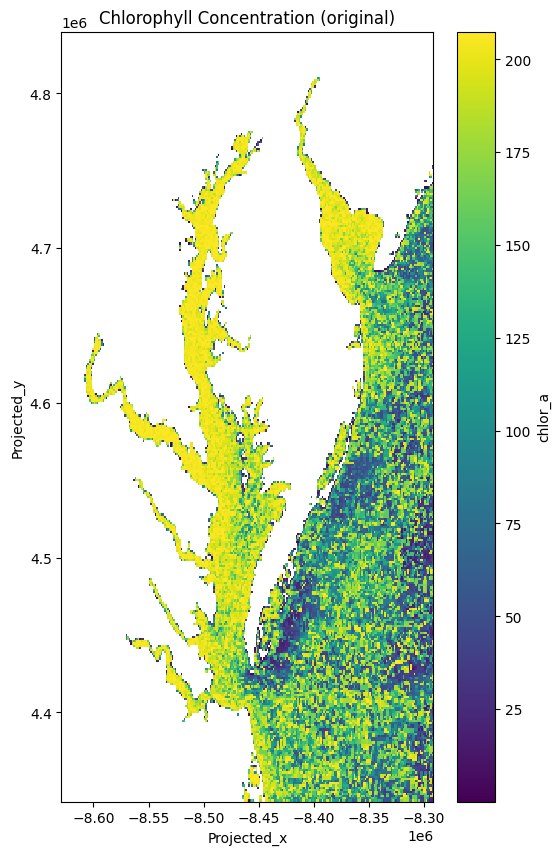

In [92]:
plt.figure(figsize=(6, 10))

# Calculate the mean across the time dimension for the current variable
variable_mean = satellite_data['chlor_a'].max(dim='time', skipna=True).isel(level=0)

# Plot the variable using xarray
variable_mean.plot(cmap='viridis')

# Add labels and title
plt.title('Chlorophyll Concentration (original)')
plt.xlabel('Projected_x')
plt.ylabel('Projected_y')

# Show the plot
plt.show()

In [93]:
# Extract the lat/lon coordinates
lon_coords = satellite_data['lon'].values  # Longitude coordinates
lat_coords = satellite_data['lat'].values  # Latitude coordinates

# Create a 2D grid from the 1D lat/lon arrays
# lon_grid, lat_grid = np.meshgrid(lon_coords, lat_coords, indexing='xy')

In [94]:
def xarray_select_variables(ds):
    
    latitude = ds['lat'].values
    longitude = ds['lon'].values

    spatial_dims = ('y', 'x')
    
    # Stack the 'chlor_a' variable based on detected spatial dimensions and get the flattened array
    var_flat = ds['chlor_a'].stack(spatial=spatial_dims).values


    # Remove duplicate lat/lon points to ensure unique lat/lon coordinates if needed
    lat_unique, lon_unique = np.unique(latitude)[::-1], np.unique(longitude)

    # Rename level
    ds = ds.rename({'level':'depth'})

    # Initialize the new dataset with reshaped data
    new_ds = xr.Dataset(
        {
            'chlor_a': (('time', 'depth', 'lat', 'lon'), var_flat.reshape(ds['time'].size, ds['depth'].size, len(lat_unique), len(lon_unique)))
        },
        coords={
            'time': ds['time'],
            'depth': ds['depth'],
            'lat': lat_unique,
            'lon': lon_unique
        }
    )

    # Step 6: Dynamically copy metadata for all data variables
    for var in ds.data_vars:
        # Check if the variable exists in the new dataset and copy metadata
        if var in new_ds.data_vars:
            new_ds[var].attrs = ds[var].attrs  # Copy the metadata dynamically

    # Step 7: Dynamically copy metadata for all coordinates (no hardcoding)
    for coord in ds.coords:
        # If the coordinate exists in the new dataset, copy metadata
        if coord in new_ds.coords:
            new_ds[coord].attrs = ds[coord].attrs

    new_ds['lat'].attrs = ds['lat'].attrs  # Copy longitude metadata

    new_ds['lon'].attrs = ds['lon'].attrs  # Copy longitude metadata

    new_ds.attrs = ds.attrs

    # Check the new dataset structure
    return new_ds


In [95]:
satellite_data_reindex= xarray_select_variables(satellite_data)
satellite_data_reindex

<xarray.Dataset> Size: 963MB
Dimensions:  (time: 2767, depth: 1, lat: 358, lon: 243)
Coordinates:
  * time     (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-10-30T17...
  * depth    (depth) float64 8B 0.0
  * lat      (lat) float64 3kB 40.01 40.0 39.99 39.98 ... 36.52 36.51 36.5 36.49
  * lon      (lon) float64 2kB -77.51 -77.5 -77.49 ... -74.51 -74.5 -74.49
Data variables:
    chlor_a  (time, depth, lat, lon) float32 963MB nan nan nan ... 0.2937 0.3537

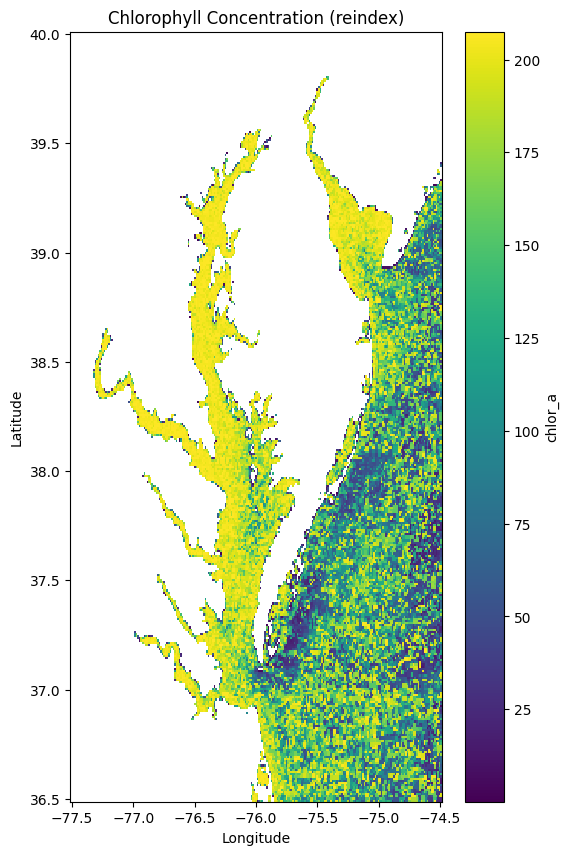

In [96]:
plt.figure(figsize=(6, 10))

# Calculate the mean across the time dimension for the current variable
variable_mean = satellite_data_reindex['chlor_a'].max(dim='time', skipna=True).isel(depth=0)

# Plot the variable using xarray
variable_mean.plot(cmap='viridis')

# Add labels and title
plt.title('Chlorophyll Concentration (reindex)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [97]:
for var in satellite_data_reindex.data_vars:
    data = satellite_data_reindex[var]
    total_values = np.prod(data.shape)
    nan_values = np.isnan(data).sum().item()
    percent_nan = (nan_values / total_values) * 100
    print(f"Percentage of NaN values in '{var}': {percent_nan:.2f}%")

Percentage of NaN values in 'chlor_a': 87.22%


## Preparing the buoy data

### Read and clean the dataset

In [249]:
# read in Jun's buoy data
buoy_df = pd.read_csv('../../data/plank_ChesapeakeBay_all_buoys.csv')
buoy_timestamped = process_buoy_datetime(buoy_df, 'Sample_year', 'Sample_month', 'Sample_day', 'Sample_hour', 'Sample_minute', 'Sample_second')

The buoy data also contains columns with `QC` that describe the quality of the reading. Since we do not need that information, let's drop those columns.

In [250]:
buoy_timestamped = buoy_timestamped.loc[:, ~buoy_timestamped.columns.str.contains('QC')]

There were also some issues with the way the data was combined, let's fix that.

In [251]:
buoy_timestamped = buoy_timestamped.drop(columns=['Latitude_y','Longitude_y'])


And some more cleaning to remove invalid latitude and longitude measurements.

In [252]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(buoy_data):
    # Filter rows based on column: 'Longitude_x'
    buoy_data = buoy_data[(buoy_data['Longitude_x'].notna()) & (buoy_data['Longitude_x'] < -70) & (buoy_data['Longitude_x'] > -80)]
    # Filter rows based on column: 'Latitude_x'
    buoy_data = buoy_data[(buoy_data['Latitude_x'].notna()) & (buoy_data['Latitude_x'] > 35) & (buoy_data['Latitude_x'] < 40)]
    # Rename column 'Latitude_x' to 'Latitude'
    buoy_data = buoy_data.rename(columns={'Latitude_x': 'Latitude','Longitude_x': 'Longitude'})
    return buoy_data

buoy_data_clean = clean_data(buoy_timestamped.copy())
buoy_data_clean.columns

Index(['Latitude', 'Longitude', 'Air Temperature', 'Air pressure', 'Humidity',
       'Wind speed', 'Wind Direction', 'Temperature', 'Salinity',
       'Chlorophyll', 'Turbidity', 'Oxygen', 'Significant wave height',
       'Wave from direction', 'Wave period', 'North surface currents',
       'East surface currents', 'timestamp'],
      dtype='object')

The next step is preparing the data to align with our satellite data.  Since the buoys move a bit, the latitude and longitude values should be rounded before aggregation. The satellite data uses two decimal places, and that should also be reasonable for the buoy data.Since the buoy data is taken every 6-60 minutes, depending on the parameter, and the satellite data is roughly daily, we will use the daily mean measurements.

In [253]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(buoy_data_clean):
    # Round column 'Latitude' (Number of decimals: 2)
    buoy_data_clean = buoy_data_clean.round({'Latitude': 2})
    # Round column 'Longitude' (Number of decimals: 2)
    buoy_data_clean = buoy_data_clean.round({'Longitude': 2})
    return buoy_data_clean

buoy_data_rounded = clean_data(buoy_data_clean.copy())
buoy_data_rounded.head()

Latitude  Longitude  Air Temperature  Air pressure  Humidity  Wind speed  \
1      39.2     -76.57             14.4       1028.18      66.8         1.0   
2      39.2     -76.57             14.4       1028.22      67.1         0.9   
3      39.2     -76.57             14.4       1028.30      67.2         1.0   
5      39.2     -76.57             14.4       1028.01      67.7         1.0   
6      39.2     -76.57             14.5       1027.94      68.2         0.9   

   Wind Direction  Temperature  Salinity  Chlorophyll  Turbidity  Oxygen  \
1           155.0          NaN       NaN          NaN        NaN     NaN   
2           164.0          NaN       NaN          NaN        NaN     NaN   
3           182.0          NaN       NaN          NaN        NaN     NaN   
5           174.0          NaN       NaN          NaN        NaN     NaN   
6           183.0          NaN       NaN          NaN        NaN     NaN   

   Significant wave height  Wave from direction  Wave period  \
1                      NaN                  NaN          NaN   
2                      NaN                  NaN          NaN   
3                      NaN                  NaN          NaN   
5                      NaN                  NaN          NaN   
6                      0.0                137.8          5.1   

   North surface currents  East surface currents           timestamp  
1                     NaN                    NaN 2009-11-18 19:10:00  
2                     NaN                    NaN 2009-11-18 19:20:00  
3                     NaN                    NaN 2009-11-18 19:30:00  
5                     NaN                    NaN 2009-11-18 19:50:00  
6                  656.13                6242.61 2009-11-18 20:00:00

In [254]:
# Assuming buoy_data is your DataFrame
# buoy_data_rounded['timestamp'] = pd.to_datetime(buoy_data_rounded['timestamp'])  # Convert to datetime if not already
buoy_data_rounded.set_index('timestamp', inplace=True)  # Set the timestamp as the index

# Group by date and latitude/longitude, aggregating measurement columns
daily_aggregate = (
    buoy_data_rounded.groupby([buoy_data_rounded.index.date, 'Latitude', 'Longitude'])
    .agg('mean')  # Default behavior is to calculate the mean, ignoring NaNs
    .reset_index()
)

# Rename the date column for clarity
daily_aggregate.rename(columns={'level_0': 'Date'}, inplace=True)


Date  Latitude  Longitude  Air Temperature  Air pressure   Humidity  \
0  2007-04-25     36.02     -76.13        29.215000   1011.667750  42.947500   
1  2007-04-26     36.01     -76.14        11.966667   1018.933333  86.466667   
2  2007-04-26     36.02     -76.13        16.616279   1016.557674  77.915504   
3  2007-04-27     36.02     -76.13        20.625874   1012.079790  81.541958   
4  2007-04-28     36.02     -76.13        19.752083   1010.187431  77.270833   

   Wind speed  Wind Direction  Temperature  Salinity  Chlorophyll  Turbidity  \
0    4.062500      226.100000          NaN       NaN          NaN        NaN   
1    0.366667      331.166667          NaN       NaN          NaN        NaN   
2    1.196124      230.984496          NaN       NaN          NaN        NaN   
3    2.308392      205.846154          NaN       NaN          NaN        NaN   
4    1.111806      166.201389          NaN       NaN          NaN        NaN   

   Oxygen  Significant wave height  Wave from direction  Wave period  \
0     NaN                      NaN                  NaN          NaN   
1     NaN                      NaN                  NaN          NaN   
2     NaN                      NaN                  NaN          NaN   
3     NaN                      NaN                  NaN          NaN   
4     NaN                      NaN                  NaN          NaN   

   North surface currents  East surface currents  
0                     NaN                    NaN  
1                     NaN                    NaN  
2                     NaN                    NaN  
3                     NaN                    NaN  
4                     NaN                    NaN

Finally, we will only retain parameters with data in at least 10% of the rows.

In [257]:
threshold = 0.1

missing_percentage = daily_aggregate.isnull().mean()

columns_to_keep = missing_percentage[missing_percentage <= threshold].index

# Create a new DataFrame with only the columns to keep
daily_aggregate = daily_aggregate[columns_to_keep]

print('Remaining columns:', daily_aggregate.columns)

Remaining columns: Index(['Date', 'Latitude', 'Longitude', 'Air Temperature', 'Air pressure',
       'Wind speed', 'Wind Direction'],
      dtype='object')


In [258]:
daily_aggregate.dtypes

Date                object
Latitude           float64
Longitude          float64
Air Temperature    float64
Air pressure       float64
Wind speed         float64
Wind Direction     float64
dtype: object

Now we can save this aggregated data in a CSV to access later.

In [259]:
daily_aggregate.to_csv('../../data/buoy_aggregate.csv', index=False)

### Aggregate by date

We will read in the buoy data, then create a dictionary that aggreates the data by day. This dictionary will save time when aligning with the satellite data, as the grouping csv rows takes time.

In [260]:
# Load buoy data from CSV
buoy_data = pd.read_csv('../../data/buoy_aggregate.csv')

buoy_data['Date'] = pd.to_datetime(buoy_data['Date'])
buoy_data.columns

Index(['Date', 'Latitude', 'Longitude', 'Air Temperature', 'Air pressure',
       'Wind speed', 'Wind Direction'],
      dtype='object')

Now we need to group the rows by date so that we can merge with the corresponding satellite data.

In [261]:
def preprocess_dataframe_by_date(df):
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    # Group DataFrame by date
    grouped_data = {date: group for date, group in df.groupby('Date')}
    return grouped_data

buoy_dates_dict = preprocess_dataframe_by_date(buoy_data)

In [262]:
satellite_data_reindex

<xarray.Dataset> Size: 963MB
Dimensions:  (time: 2767, depth: 1, lat: 358, lon: 243)
Coordinates:
  * time     (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-10-30T17...
  * depth    (depth) float64 8B 0.0
  * lat      (lat) float64 3kB 40.01 40.0 39.99 39.98 ... 36.52 36.51 36.5 36.49
  * lon      (lon) float64 2kB -77.51 -77.5 -77.49 ... -74.51 -74.5 -74.49
Data variables:
    chlor_a  (time, depth, lat, lon) float32 963MB nan nan nan ... 0.2937 0.3537

## Combining into one xarray

We need to to add the variables from the buoy data to the satellite data. First, we will find the buoy data for the correct date. Then, for each location in the the xarray, we find the closest buoy and attach the daily mean measurement for each of the variables.

Since we already filtered the chlorophyll data to only the Chesapeake Bay, we will use `chlor_a` to create a mask.

In [263]:
def merge_and_clean_xarray(ds, grouped_data):
    try:
        
        # Define the variable with the date for the xarray
        for time_value in ds['time'].values:
            # Extract date for each time value
            date_value = pd.to_datetime(time_value, unit='s').date()

            if date_value not in grouped_data:
                raise ValueError(f"No matching rows found for date: {date_value}")

            df_filtered = grouped_data[date_value]

            # Define where to find latitude and longitude
            latitudes = ds['lat'].values
            longitudes = ds['lon'].values
            csv_lat = df_filtered['Latitude'].values
            csv_lon = df_filtered['Longitude'].values
            
            # Create a 2D meshgrid of lat/lon for the xarray data
            lat_grid, lon_grid = np.meshgrid(latitudes, longitudes, indexing='ij')

            # Flatten the meshgrid into coordinate pairs (for xarray points)
            points = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))  # Xarray lat/lon pairs

            csv_points = np.column_stack((csv_lat, csv_lon))   # CSV lat/lon points

            closest_data = {}
            for col in df_filtered.columns:
                if col not in ['Latitude', 'Longitude', 'Date']:
                    # Extract the data values for the current variable
                    values = df_filtered[col].values  # Shape (n_csv_points,)

                    # Initialize the RBFInterpolator for the current variable
                    rbf_interpolator = RBFInterpolator(csv_points, values, kernel='linear')

                    # Perform the interpolation on the target points
                    interpolated_values = rbf_interpolator(points)  # Shape (n_lat * n_lon,)

                    # Reshape the interpolated values to match the xarray grid shape
                    interpolated_values = interpolated_values.reshape(lat_grid.shape)  # Shape (n_lat, n_lon)

                    # Assign the interpolated data to closest_data
                    closest_data[col] = interpolated_values


            new_ds = ds.copy(deep=True)
            for col, values in closest_data.items():
                new_ds[col] = (('lat','lon'), values)  # Use 'lat' dimension for closest values

            return new_ds

    except Exception as e:
        raise RuntimeError(f"Error merging and cleaning xarray: {str(e)}")

In [269]:
merged_data = merge_and_clean_xarray(satellite_data_reindex,buoy_dates_dict)

In [270]:
# List of variables to expand
variables_to_expand = ['Air Temperature', 'Air pressure', 'Wind speed', 'Wind Direction']

# Expand variables to have dimensions (time, depth, lat, lon)
for var in variables_to_expand:
    merged_data[var] = merged_data[var].expand_dims({'time': merged_data.time, 'depth': merged_data.depth})

In [271]:
merged_data

<xarray.Dataset> Size: 9GB
Dimensions:          (time: 2767, depth: 1, lat: 358, lon: 243)
Coordinates:
  * time             (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-...
  * depth            (depth) float64 8B 0.0
  * lat              (lat) float64 3kB 40.01 40.0 39.99 ... 36.51 36.5 36.49
  * lon              (lon) float64 2kB -77.51 -77.5 -77.49 ... -74.5 -74.49
Data variables:
    chlor_a          (time, depth, lat, lon) float32 963MB nan nan ... 0.3537
    Air Temperature  (time, depth, lat, lon) float64 2GB 25.49 25.49 ... 25.08
    Air pressure     (time, depth, lat, lon) float64 2GB 1.014e+03 ... 1.012e+03
    Wind speed       (time, depth, lat, lon) float64 2GB 3.552 3.561 ... 4.786
    Wind Direction   (time, depth, lat, lon) float64 2GB 281.1 281.0 ... 260.2

## Dealing with missing values

In [272]:
cleaned_data = merged_data

cleaned_data['Wind_Direction_rad'] = np.deg2rad(cleaned_data['Wind Direction'])
cleaned_data['Wind_Direction_sin'] = np.sin(cleaned_data['Wind_Direction_rad'])
cleaned_data['Wind_Direction_cos'] = np.cos(cleaned_data['Wind_Direction_rad'])
# Interpolate along the time dimension
cleaned_data['Wind_Direction_sin'] = cleaned_data['Wind_Direction_sin'].interpolate_na(dim='time', method='linear')
cleaned_data['Wind_Direction_cos'] = cleaned_data['Wind_Direction_cos'].interpolate_na(dim='time', method='linear')
# Recalculate wind direction from interpolated sine and cosine, and adjust range to [0, 2π)
cleaned_data['Wind_Direction_interp_rad'] = np.arctan2(cleaned_data['Wind_Direction_sin'], cleaned_data['Wind_Direction_cos'])
cleaned_data['Wind_Direction_interp_rad'] = np.mod(cleaned_data['Wind_Direction_interp_rad'], 2 * np.pi)

# Replace original Wind Direction with interpolated values
cleaned_data['Wind Direction'] = cleaned_data['Wind_Direction_interp_rad']
# Drop intermediate variables if not needed
cleaned_data = cleaned_data.drop_vars(['Wind_Direction_rad', 'Wind_Direction_sin', 'Wind_Direction_cos', 'Wind_Direction_interp_rad'])

In [273]:
variables_linear = ['chlor_a', 'Air Temperature', 'Air pressure', 'Wind speed']

for var in variables_linear:
    cleaned_data[var] = cleaned_data[var].interpolate_na(dim='time', method='linear')

In [274]:
cleaned_data

<xarray.Dataset> Size: 9GB
Dimensions:          (time: 2767, depth: 1, lat: 358, lon: 243)
Coordinates:
  * time             (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-...
  * depth            (depth) float64 8B 0.0
  * lat              (lat) float64 3kB 40.01 40.0 39.99 ... 36.51 36.5 36.49
  * lon              (lon) float64 2kB -77.51 -77.5 -77.49 ... -74.5 -74.49
Data variables:
    chlor_a          (time, depth, lat, lon) float32 963MB nan nan ... 0.3537
    Air Temperature  (time, depth, lat, lon) float64 2GB 25.49 25.49 ... 25.08
    Air pressure     (time, depth, lat, lon) float64 2GB 1.014e+03 ... 1.012e+03
    Wind speed       (time, depth, lat, lon) float64 2GB 3.552 3.561 ... 4.786
    Wind Direction   (time, depth, lat, lon) float64 2GB 4.907 4.905 ... 4.541

Finally, we normalize the data. We scale the weather data to be between 0 and 1. Let's check the statistics for the variables.

In [275]:
# List of features to normalize (excluding the target 'chlor_a')
variables_to_normalize = ['Air Temperature', 'Air pressure', 'Wind speed', 'Wind Direction']

for var in variables_to_normalize:
    # Compute the min and max values across time, depth, lat, and lon
    var_min = cleaned_data[var].min(dim=('time', 'depth', 'lat', 'lon'))
    var_max = cleaned_data[var].max(dim=('time', 'depth', 'lat', 'lon'))

    # Apply min-max scaling
    cleaned_data[var] = (cleaned_data[var] - var_min) / (var_max - var_min)

We can also plot the chlorophyll values to determine the best way to scale the data.

(array([6.5787854e+07, 8.2225430e+06, 4.2403720e+06, 2.4393070e+06,
        1.5872200e+06, 1.1061350e+06, 7.8703200e+05, 5.5954300e+05,
        4.2393900e+05, 3.3673600e+05, 2.7689800e+05, 2.3518600e+05,
        2.0159900e+05, 1.7075400e+05, 1.4775100e+05, 1.2798900e+05,
        1.1202600e+05, 9.4237000e+04, 7.8815000e+04, 6.5300000e+04,
        5.2850000e+04, 4.1292000e+04, 3.0992000e+04, 2.2261000e+04,
        1.3919000e+04]),
 array([  0.        ,   8.2993269 ,  16.59865379,  24.89797974,
         33.19730759,  41.49663544,  49.79595947,  58.09528732,
         66.39461517,  74.69393921,  82.99327087,  91.29259491,
         99.59191895, 107.89125061, 116.19057465, 124.48989868,
        132.78923035, 141.08856201, 149.38787842, 157.68721008,
        165.98654175, 174.28585815, 182.58518982, 190.88452148,
        199.18383789, 207.48316956]),
 <BarContainer object of 25 artists>)

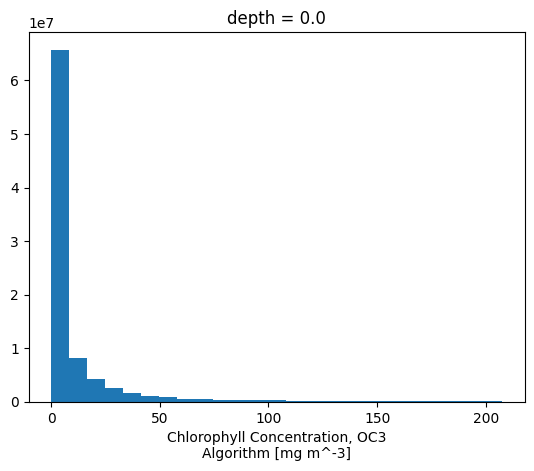

In [35]:
cleaned_data['chlor_a'].plot.hist(bins=25)

Trying a log transformation

(array([  98823., 2709133., 5818980., 5745360., 5186317., 4639108.,
        4412897., 4090371., 3694371., 3384319., 3119220., 2937149.,
        2796802., 2732229., 2647963., 2476601., 2248686., 2035341.,
        1871379., 1727287., 1602025., 1508094., 1438069., 1385208.,
        1340936., 1292600., 1254007., 1229547., 1195966., 1129796.,
        1041020.,  958526.,  880009.,  820727.,  750453.,  688938.,
         628159.,  554867.,  477124.,  411320.,  366612.,  327992.,
         298380.,  272796.,  241447.,  215303.,  184485.,  144341.,
          99404.,   52063.]),
 array([0.        , 0.10679717, 0.21359435, 0.32039151, 0.42718869,
        0.53398585, 0.64078301, 0.74758017, 0.85437739, 0.96117455,
        1.06797171, 1.17476892, 1.28156602, 1.38836324, 1.49516034,
        1.60195756, 1.70875478, 1.81555188, 1.9223491 , 2.02914619,
        2.13594341, 2.24274063, 2.34953785, 2.45633483, 2.56313205,
        2.66992927, 2.77672648, 2.8835237 , 2.99032068, 3.0971179 ,
        3.20391512

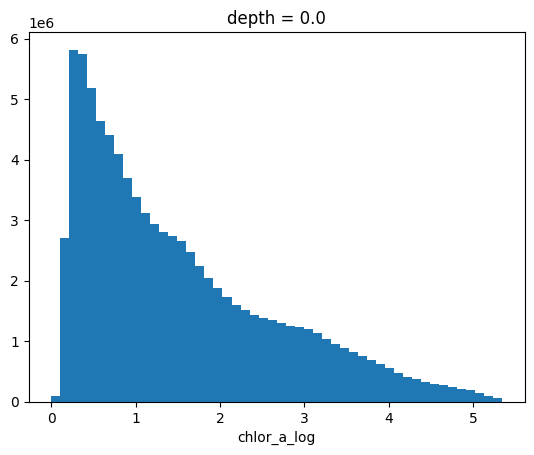

In [276]:
# Apply log transformation to chlor_a, adding 1 to avoid log(0)
cleaned_data['chlor_a_log'] = np.log(cleaned_data['chlor_a'] + 1)

# Check the distribution after the transformation
cleaned_data['chlor_a_log'].plot.hist(bins=50)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


(array([1777886., 1682977., 1805522., 1748503., 1673642., 1636314.,
        1795174., 1650399., 1842474., 1633583., 1791935., 1669355.,
        1880403., 1576237., 2061843., 1561579., 1853666., 1678319.,
        1782510., 1761016., 1678820., 1760584., 1686530., 1611348.,
        1868893., 2031268., 1667140., 1691999., 1842702., 1427331.,
        1690423., 1764961., 1695780., 1802265., 1457156., 1698034.,
        1704178., 1799796., 1743670., 1749241., 1704440., 1671947.,
        1918237., 1892518., 1772737., 1586837., 1635792., 1948345.,
        2082400., 1713841.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

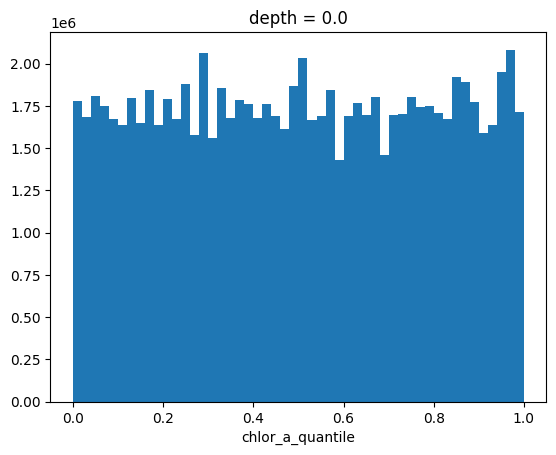

In [277]:
import numpy as np
from sklearn.preprocessing import QuantileTransformer

# Extract chlor_a values and flatten the data, remove NaN values
chlor_a_values = cleaned_data['chlor_a'].values.flatten()
chlor_a_values = chlor_a_values[~np.isnan(chlor_a_values)]  # Remove NaN values

# Reshape the data to a 2D array (required by QuantileTransformer)
chlor_a_values = chlor_a_values.reshape(-1, 1)

# Apply quantile transformation to map the data to a uniform distribution
quantile_transformer = QuantileTransformer(output_distribution='uniform', n_quantiles=1000, random_state=0)
chlor_a_quantile = quantile_transformer.fit_transform(chlor_a_values)

# Reshape the transformed data back to the original chlor_a shape
chlor_a_quantile_reshaped = np.full(cleaned_data['chlor_a'].shape, np.nan)
chlor_a_quantile_reshaped[~np.isnan(cleaned_data['chlor_a'].values)] = chlor_a_quantile.flatten()

# Add transformed data back into the xarray dataset
cleaned_data['chlor_a_quantile'] = (('time', 'depth', 'lat', 'lon'), chlor_a_quantile_reshaped)

cleaned_data['chlor_a_quantile'].plot.hist(bins=50)


In [278]:
cleaned_data['chlor_a'] = cleaned_data['chlor_a_quantile']
cleaned_data = cleaned_data.drop_vars(['chlor_a_quantile','chlor_a_log'])

In [279]:
cleaned_data

<xarray.Dataset> Size: 10GB
Dimensions:          (time: 2767, depth: 1, lat: 358, lon: 243)
Coordinates:
  * time             (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-...
  * depth            (depth) float64 8B 0.0
  * lat              (lat) float64 3kB 40.01 40.0 39.99 ... 36.51 36.5 36.49
  * lon              (lon) float64 2kB -77.51 -77.5 -77.49 ... -74.5 -74.49
Data variables:
    chlor_a          (time, depth, lat, lon) float64 2GB nan nan ... 0.08785
    Air Temperature  (time, depth, lat, lon) float64 2GB 0.5957 ... 0.3961
    Air pressure     (time, depth, lat, lon) float64 2GB 0.4485 ... 0.05278
    Wind speed       (time, depth, lat, lon) float64 2GB 0.3479 ... 0.5927
    Wind Direction   (time, depth, lat, lon) float64 2GB 0.8337 ... 0.7091

In [281]:
cleaned_data.to_netcdf('../../data/satelliteBuoy_clean.nc4')

In [55]:
for var in cleaned_data.data_vars:
    data = cleaned_data[var]
    total_values = np.prod(data.shape)
    nan_values = np.isnan(data).sum().item()
    percent_nan = (nan_values / total_values) * 100
    print(f"Percentage of NaN values in '{var}': {percent_nan:.2f}%")


Percentage of NaN values in 'chlor_a': 63.79%
Percentage of NaN values in 'Air Temperature': 0.00%
Percentage of NaN values in 'Air pressure': 0.00%
Percentage of NaN values in 'Humidity': 0.00%
Percentage of NaN values in 'Wind speed': 0.00%
Percentage of NaN values in 'Wind Direction': 0.00%


## Masking datasets with shape file

We only want to work with data from the Chesapeake Bay proper. Additionally, for latitude and longitude points corresponding to land instead of water, the chlorophyll value is always set to `-1`, which will create false correlations in the analysis.

These shape firls come from the EPA and Chesapeake Bay Foundation definitions of the 92 regions of the Chesapeake Bay Watershed, accessed via [ArcGIS Hub](https://hub.arcgis.com/datasets/ChesBay::chesapeake-bay-92-segments/about).

In [3]:
import geopandas as gpd
import shapely
from shapely.ops import unary_union
from shapely.geometry import Polygon
from shapely.vectorized import contains
from pyproj import Transformer


Skipping the previous sections by reading in the file

And now the shape file.

In [283]:
shapefile_path = '../../data/shapeFiles/Chesapeake_Bay_92_Segments.shp'
gdf = gpd.read_file(shapefile_path).drop(columns=['OBJECTID'])

# Combine segments that are two states
gdf['CBSEG_92_base'] = gdf['CBSEG_92'].str.split('_').str[0]

grouped_gdf = gdf.groupby(['CBSEG_92_base', 'BasinGroup','Name']).agg({
    'geometry': lambda geom: unary_union(geom),  # Combine geometries
    'STATE': lambda x: ', '.join(x.dropna().unique()),  # Combine all unique STATE values, separated by commas
}).reset_index()

# Rename CBSEG_92_base back to CBSEG_92 if you prefer
gdf = grouped_gdf.rename(columns={'CBSEG_92_base': 'CBSEG_92'})

# Convert from projected coordinates to latitude and longitude
transformer_reverse = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)


# Apply the transformation to each geometry in the GeoDataFrame
gdf['geometry'] = gdf['geometry'].apply(lambda geom: shapely.ops.transform(transformer_reverse.transform, geom))

In [284]:
gdf.columns

Index(['CBSEG_92', 'BasinGroup', 'Name', 'geometry', 'STATE'], dtype='object')

Next, we will combine the shape files for the relevant regions: the Chesapeake Bay proper, which start with `CB`, Eastern Bay `EASMH`, Mobjack Bay `MOBPH`, and Tangier Sound `TANMH_MD` and `TANMH_VA`.

In [285]:
filtered_gdf = gdf[
    (gdf['CBSEG_92'].astype(str).str.startswith('CB')) |
    (gdf['CBSEG_92'] == 'EASMH') |
    (gdf['CBSEG_92'] == 'MOBPH') |
    (gdf['CBSEG_92'] == 'TANMH')
]

combined_polygon = gpd.GeoSeries(filtered_gdf['geometry'].geometry).union_all()

print(combined_polygon)

POLYGON ((-76.42744159653942 37.45892101256697, -76.42771583958347 37.458775744908145, -76.4274870452964 37.458523892009474, -76.4269913616214 37.45845101645122, -76.42694530200612 37.45816540929597, -76.4275784988711 37.45805636424142, -76.4280287796035 37.45784137131049, -76.42757117216462 37.45729936170181, -76.428113128357 37.45690750731215, -76.42744138184071 37.456437934960015, -76.42770867996471 37.45615079621263, -76.42861634086073 37.45607673387437, -76.42829577409498 37.455717836523874, -76.428479222932 37.45549930697303, -76.43001225721498 37.45542668518746, -76.43015012793676 37.45474453485458, -76.4305544622423 37.45453008863631, -76.43131759316258 37.45452985972485, -76.43208794209252 37.45424112267537, -76.4324465087371 37.45431338619878, -76.43267552940108 37.4548175901646, -76.43295027909821 37.45492241544241, -76.433132913158 37.45445828457185, -76.4330413059704 37.453842004759345, -76.43317922070993 37.45370063089569, -76.43385051986236 37.45420172050593, -76.4341250

In [286]:
# Extract x and y coordinates from the polygon's exterior
x, y = combined_polygon.exterior.xy

# Find the range of x and y
x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)

print(f"Range of x (Longitude): {x_min} to {x_max}")
print(f"Range of y (Latitude): {y_min} to {y_max}")


Range of x (Longitude): -76.56941380700695 to -75.73461468945172
Range of y (Latitude): 36.907351828374516 to 39.60900009147974


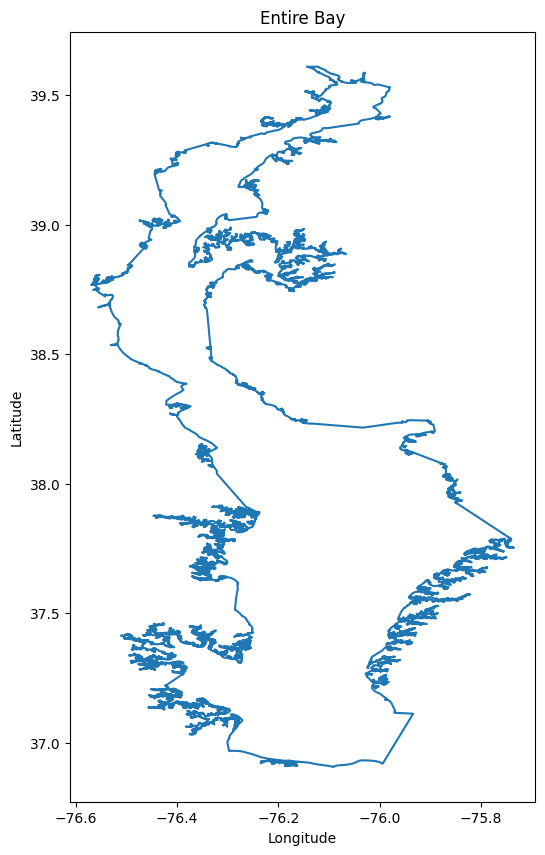

In [288]:
import matplotlib.pyplot as plt

# Adjust the figure size (width, height)
plt.figure(figsize=(6,10)) 

# Plot the polygon
x, y = combined_polygon.exterior.xy
plt.plot(x, y)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Entire Bay')

# Show the plot
plt.show()

Now we will create a latitude and longitude grid and use the polygon to restrict our data.

In [289]:
import numpy as np
import xarray as xr
from shapely.vectorized import contains
from tqdm import tqdm

def polygon_mask(ds, polygon):
    # Extract the lat/lon coordinates
    lon_coords = ds['lon'].values  # Longitude coordinates
    lat_coords = ds['lat'].values  # Latitude coordinates
    
    # Create a 2D grid from the 1D lat/lon arrays
    lon_grid, lat_grid = np.meshgrid(lon_coords, lat_coords, indexing='xy')

    # Create a boolean mask using Shapely's vectorized contains method
    print("Creating polygon mask...")
    mask_2d = contains(polygon, lon_grid.flatten(), lat_grid.flatten()).reshape(lon_grid.shape)

    # Convert the 2D mask to a DataArray with correct dimensions
    mask_expanded = xr.DataArray(mask_2d, dims=('lat', 'lon'), coords={'lat': ds['lat'], 'lon': ds['lon']})

    # Apply the mask to all data variables in the dataset
    print("Applying polygon mask...")
    masked_ds = ds.where(mask_expanded)  # This sets outside measurements to NaN]

    # Create a mask where all data variables are NaN across time, depth, and lon for each lat
    nan_mask_lat = masked_ds.isnull().all(dim=['depth', 'lon', 'time'])  # Check across depth, lon, and time
    nan_mask_lon = masked_ds.isnull().all(dim=['depth', 'lat', 'time'])  # Check across depth, lat, and time

    # Drop the lat coordinates where all data variables are NaN
    nan_mask = ~nan_mask_lat & ~nan_mask_lon  # Combine masks using logical AND
    masked_ds = masked_ds.where(nan_mask, drop=True)

    return masked_ds


We can use the entire Bay:

In [ ]:
masked_xarray = polygon_mask(cleaned_data,combined_polygon)

Or a region

In [295]:
import numpy as np
import xarray as xr
from shapely.vectorized import contains
from tqdm.notebook import tqdm

def assign_region_id_vectorized(df):
    """Vectorized assignment of region IDs based on CBSEG_92."""
    conditions = [
        df['CBSEG_92'].str.startswith('CB'),
        df['CBSEG_92'] == 'EASMH',
        df['CBSEG_92'] == 'MOBPH',
        df['CBSEG_92'] == 'TANMH'
    ]
    choices = [
        df['CBSEG_92'].str.extract(r'(\d+)').astype(int),  # Extract numbers for 'CB' regions
        9,  # EASMH
        10, # MOBPH
        11  # TANMH
    ]
    df['RegionID'] = np.select(conditions, choices, default=None)
    return df

def assign_salinity_zone_vectorized(df):
    conditions = [
        df['CBSEG_92'].str.endswith('TF'),
        df['CBSEG_92'].str.endswith('OH'),
        df['CBSEG_92'].str.endswith('MH'),
        df['CBSEG_92'].str.endswith('PH')
    ]
    choices = [0, 0.33, 0.67, 1]
    df['Salinity_Zone'] = np.select(conditions, choices, default=None)
    return df


def polygon_mask(ds, filtered_gdf):
    masked_xarrays = []  # List to store individual region xarrays

    # Vectorized grid creation (once for all polygons)
    lon_coords = ds['lon'].values  # Longitude coordinates
    lat_coords = ds['lat'].values  # Latitude coordinates
    lon_grid, lat_grid = np.meshgrid(lon_coords, lat_coords, indexing='xy')

    # Initialize tqdm progress bar with a total count based on filtered_gdf
    with tqdm(total=len(filtered_gdf), desc="Creating xarrays regions") as outer_pbar:
        for idx, row in filtered_gdf.iterrows():

            with tqdm(total=4, desc=f"Processing region", leave=False) as inner_pbar:
                region_id = row['CBSEG_92']
                polygon = row['geometry']
                salinity_zone = assign_salinity_zone(row['CBSEG_92'])  # Assign Salinity Zone
                print("Creating polygon mask for region {region_id}...")
                mask_2d = contains(polygon, lon_grid.flatten(), lat_grid.flatten()).reshape(lon_grid.shape)

                # Convert the 2D mask to a DataArray with correct dimensions
                mask_expanded = xr.DataArray(mask_2d, dims=('lat', 'lon'), coords={'lat': ds['lat'], 'lon': ds['lon']})
                inner_pbar.update(1)  # Progress for creating the mask

                # Apply the mask to all data variables in the dataset
                print(f"Applying polygon mask for region {region_id}...")
                masked_ds = ds.where(mask_expanded)  # This sets outside measurements to NaN
                inner_pbar.update(1)  # Progress for applying mask

                print(f"Refining mask for region {region_id}...")
                # Create a mask where all data variables are NaN across time, depth, and lon for each lat
                nan_mask_lat = masked_ds.isnull().all(dim=['lon', 'time'])  # Check across depth, lon, and time
                nan_mask_lon = masked_ds.isnull().all(dim=['lat', 'time'])  # Check across depth, lat, and time

                # Drop the coordinates where all data variables are NaN
                nan_mask = ~nan_mask_lat & ~nan_mask_lon  # Combine masks using logical AND
                masked_ds = masked_ds.where(nan_mask, drop=True)
                inner_pbar.update(1)  # Progress for refining the mask

                print(f"Adding in region data for region {region_id}...")
                salinity_zone_array = xr.DataArray(
                    salinity_zone * np.ones_like(masked_ds['chlor_a'].values),  # Assume a variable like chlor_a for shape
                    dims=('time', 'depth', 'lat', 'lon'),
                    coords={'time': masked_ds['time'], 'depth': masked_ds['depth'], 'lat': masked_ds['lat'], 'lon': masked_ds['lon']}
                )
                masked_ds = masked_ds.assign({'Salinity_Zone': salinity_zone_array})
                # # Add Region ID as a new coordinate
                # Handle in dictionary/metadata
                # masked_ds = masked_ds.assign_coords({'RegionID': region_id})
                # masked_ds = masked_ds.expand_dims('RegionID')

                # Add metadata as attributes
                masked_ds.attrs['State'] = row['STATE']
                masked_ds.attrs['BasinGroup'] = row['BasinGroup']
                masked_ds.attrs['Name'] = row['Name']
                masked_ds.attrs['CBSeg2003'] = region_id

                masked_xarrays.append(masked_ds)
                inner_pbar.update(1)  # Progress for adding xarray
            
            outer_pbar.update(1)
    return masked_xarrays  # Return list of masked xarrays for each reg


In [ ]:
filtered_gdf = gdf[
    (gdf['CBSEG_92'].astype(str).str.startswith('CB')) |
    (gdf['CBSEG_92'] == 'EASMH') |
    (gdf['CBSEG_92'] == 'MOBPH') |
    (gdf['CBSEG_92'] =='TANMH')
]

region_xarray_list = polygon_mask(cleaned_data,filtered_gdf)

In [297]:
region_xarray_list[1]

<xarray.Dataset> Size: 85MB
Dimensions:          (time: 2767, depth: 1, lat: 22, lon: 29)
Coordinates:
  * time             (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-...
  * depth            (depth) float64 8B 0.0
  * lat              (lat) float64 176B 39.42 39.41 39.4 ... 39.23 39.22 39.21
  * lon              (lon) float64 232B -76.4 -76.39 -76.37 ... -76.06 -76.05
Data variables:
    chlor_a          (time, depth, lat, lon) float64 14MB nan nan ... nan nan
    Air Temperature  (time, depth, lat, lon) float64 14MB nan nan ... nan nan
    Air pressure     (time, depth, lat, lon) float64 14MB nan nan ... nan nan
    Wind speed       (time, depth, lat, lon) float64 14MB nan nan ... nan nan
    Wind Direction   (time, depth, lat, lon) float64 14MB nan nan ... nan nan
    Salinity_Zone    (time, depth, lat, lon) float64 14MB 0.33 0.33 ... 0.33
Attributes:
    State:       MD
    BasinGroup:  MD MAIN
    Name:        Upper Chesapeake Bay
    CBSeg2003:   CB2OH

In [298]:
for idx, masked_ds in enumerate(region_xarray_list):
    # region_id = masked_ds.RegionID.values[0]  # Assuming RegionID is a scalar coordinate
    filename = f"../../data/filesForModel/nc4/satelliteBuoy_region{idx}.nc4"
    masked_ds.to_netcdf(filename, format='NETCDF4')


### Prepare to feed into the model

In [4]:
# satellite_buoy = masked_xarray
#or if you skipped previous section
# satellite_buoy = xr.open_dataset('../../data/satelliteBuoy_clean_masked.nc4')
satellite_buoy_list= [] 
for i in range(1,12):
    satellite_buoy_list.append(xr.open_dataset(f"../../data/filesForModel/nc4/satelliteBuoy_region{i}.nc4"))

In [4]:
for data in satellite_buoy_list:
    print(data.dims)

FrozenMappingWarningOnValuesAccess({'time': 2767, 'depth': 1, 'lat': 22, 'lon': 29})
FrozenMappingWarningOnValuesAccess({'time': 2767, 'depth': 1, 'lat': 25, 'lon': 18})
FrozenMappingWarningOnValuesAccess({'time': 2767, 'depth': 1, 'lat': 64, 'lon': 23})
FrozenMappingWarningOnValuesAccess({'time': 2767, 'depth': 1, 'lat': 52, 'lon': 26})
FrozenMappingWarningOnValuesAccess({'time': 2767, 'depth': 1, 'lat': 32, 'lon': 31})
FrozenMappingWarningOnValuesAccess({'time': 2767, 'depth': 1, 'lat': 65, 'lon': 15})
FrozenMappingWarningOnValuesAccess({'time': 2767, 'depth': 1, 'lat': 84, 'lon': 34})
FrozenMappingWarningOnValuesAccess({'time': 2767, 'depth': 1, 'lat': 18, 'lon': 27})
FrozenMappingWarningOnValuesAccess({'time': 2767, 'depth': 1, 'lat': 24, 'lon': 22})
FrozenMappingWarningOnValuesAccess({'time': 2767, 'depth': 1, 'lat': 38, 'lon': 17})
FrozenMappingWarningOnValuesAccess({'time': 2767, 'depth': 1, 'lat': 46, 'lon': 27})


We will combine the latitude and longitude coordinates into one `position` coordinate. This will make it easier to restrict the data to the latitude and longitude points inside the Bay. We need to make sure this is done in a unique way, but we need a 1D representation that can be fed into our tensors.

In [18]:
def final_masking_step(ds):
    stacked_data = ds.stack(position=("lat", "lon"))
    mask = ~stacked_data.isnull().all(dim=["time", "depth"])
    masked_stacked_data = stacked_data.where(mask, drop=True)
    nan_mask_lat = ds.isnull().all(dim=['lon', 'time','depth'])  # Check across depth, lon, and time
    nan_mask_lon = ds.isnull().all(dim=['lat', 'time','depth'])  # Check across depth, lat, and time

    # Drop the coordinates where all data variables are NaN
    nan_mask = ~nan_mask_lat & ~nan_mask_lon  # Combine masks using logical AND
    masked_unstacked_data =ds.where(nan_mask, drop=True)
    # masked_data = masked_data.fillna(0)
    return masked_stacked_data, masked_unstacked_data

In [32]:
masked_data_list = []
for data in satellite_buoy_list:
    masked_stacked_data,masked_unstacked_data = final_masking_step(data)  # Apply final_masking_step to 'data'
    print(f"Positions stacked data: {masked_stacked_data.position.size},Lat * lon unstacked data: {masked_unstacked_data.lat.size *masked_unstacked_data.lon.size}")
    masked_data_list.append(masked_stacked_data)
    # for var in masked_data.data_vars:
    #     data = masked_data[var]
    #     total_values = np.prod(data.shape)
    #     nan_values = np.isnan(data).sum().item()
    #     percent_nan = (nan_values / total_values) * 100
    #     print(f"Percentage of NaN values in '{var}': {percent_nan:.2f}%")



Positions stacked data: 638,Lat * lon unstacked data: 638
Positions stacked data: 450,Lat * lon unstacked data: 450
Positions stacked data: 1472,Lat * lon unstacked data: 1472
Positions stacked data: 1352,Lat * lon unstacked data: 1352
Positions stacked data: 992,Lat * lon unstacked data: 992
Positions stacked data: 975,Lat * lon unstacked data: 975
Positions stacked data: 2856,Lat * lon unstacked data: 2856
Positions stacked data: 486,Lat * lon unstacked data: 486
Positions stacked data: 528,Lat * lon unstacked data: 528
Positions stacked data: 646,Lat * lon unstacked data: 646
Positions stacked data: 1242,Lat * lon unstacked data: 1242


Now we can convert the xarray to a pytorch tensor for use in the model.

In [67]:
def xarray_to_tensors(ds):
    # Chlorophyll will not be a feature
    exclude_var = 'chlor_a'  
    included_vars = [var for var in ds.data_vars if var != exclude_var]

    # Convert all variables except the excluded one into a tensor
    data_arrays = [torch.tensor(ds[var].values,dtype=torch.float32) for var in ds.data_vars if var != exclude_var]

    # Stack the remaining tensors into one single tensor, adding a new dimension for the variables
    features_tensor = torch.stack(data_arrays, dim=2)
    # features_tensor = torch.nan_to_num(features_tensor, nan=0.0)

    # Create a dictionary mapping variable names to their corresponding tensor slices
    variable_indeces = {included_vars[i]: i for i in range(features_tensor.shape[2])}


    # Chlorophyll data
    chlorophyll_tensor = torch.tensor(ds[exclude_var].values,dtype=torch.float32)
    # chlorophyll_tensor = torch.nan_to_num(chlorophyll_tensor, nan=0.0)

    # For now, remove the depth dimension
    features_tensor = features_tensor.squeeze(1)
    chlorophyll_tensor = chlorophyll_tensor.squeeze(1)

    # Optional: Print shapes to confirm
    print(f"Features tensor shape: {features_tensor.shape}")
    print(f"Chlorophyll tensor shape: {chlorophyll_tensor.shape}")

    return features_tensor, chlorophyll_tensor, variable_indeces

In [70]:
satellite_buoy_tensors_dict = {}
variable_indeces_dict = {}
for idx, masked_data in enumerate(masked_data_list):
    features_tensor, chlorophyll_tensor,variable_indeces = xarray_to_tensors(masked_data)
    satellite_buoy_tensors_dict[f'region_{idx}'] = {"Features": features_tensor, 
                                                    "Chlorophyll": chlorophyll_tensor}
    variable_indeces_dict.update(variable_indeces)
    torch.save(features_tensor, f"../../data/filesForModel/tensors/features_region{idx}_tensor.pt")
    torch.save(chlorophyll_tensor, f"../../data/filesForModel/tensors/chlorophyll_region{idx}_tensor.pt")

with open('../../data/filesForModel/tensors/variable_indeces_dict.json', 'w') as f:
    json.dump(variable_indeces_dict,f)

Features tensor shape: torch.Size([2767, 5, 638])
Chlorophyll tensor shape: torch.Size([2767, 638])
Features tensor shape: torch.Size([2767, 5, 450])
Chlorophyll tensor shape: torch.Size([2767, 450])
Features tensor shape: torch.Size([2767, 5, 1472])
Chlorophyll tensor shape: torch.Size([2767, 1472])
Features tensor shape: torch.Size([2767, 5, 1352])
Chlorophyll tensor shape: torch.Size([2767, 1352])
Features tensor shape: torch.Size([2767, 5, 992])
Chlorophyll tensor shape: torch.Size([2767, 992])
Features tensor shape: torch.Size([2767, 5, 975])
Chlorophyll tensor shape: torch.Size([2767, 975])
Features tensor shape: torch.Size([2767, 5, 2856])
Chlorophyll tensor shape: torch.Size([2767, 2856])
Features tensor shape: torch.Size([2767, 5, 486])
Chlorophyll tensor shape: torch.Size([2767, 486])
Features tensor shape: torch.Size([2767, 5, 528])
Chlorophyll tensor shape: torch.Size([2767, 528])
Features tensor shape: torch.Size([2767, 5, 646])
Chlorophyll tensor shape: torch.Size([2767, 

In [65]:
variable_indeces_dict

{'Air Temperature': 0,
 'Air pressure': 1,
 'Wind speed': 2,
 'Wind Direction': 3,
 'Salinity_Zone': 4}

# Water Quality Dataset


## Read and clean water
For the water quality data, we will read in the CSV, drop columns that are not needed for the model. Let's drop the columns related to how the data was collected: `TotalDepth` refers to the station, `FieldActivityId`,`ProjectIdentifier`, and `Source`, `Problems`, and `Details` are about the sample collection.  `CBSeg2003` identifies the region of the Bay. `UpperPycnocline`, `LowerPycnocline`, and `Layer` are related to the layer of the water column.


In [468]:
water_quality_df = pd.read_csv('../../data/plank_ChesapeakeBayWater_pivoted.csv')

water_quality_df = water_quality_df.drop(columns=['FieldActivityId',
       'Cruise', 'ProjectIdentifier', 'Source', 'Layer', 'SampleType', 'Problem', 'Details','StationDepth','UpperPycnocline', 'LowerPycnocline'])

water_quality_timestamped = process_water_datetime(water_quality_df, 'SampleDate', 'SampleTime')

In [469]:
water_quality_timestamped.columns

Index(['CHLA', 'DIN', 'DO', 'DOC', 'DON', 'DOP', 'DO_SAT_P', 'FSS', 'KD',
       'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC', 'PH', 'PHEO', 'PIP', 'PN',
       'PO4F', 'PP', 'SALINITY', 'SECCHI', 'SIF', 'SIGMA_T', 'SPCOND', 'TDN',
       'TDP', 'TN', 'TON', 'TP', 'TSS', 'TURB_NTU', 'VSS', 'WTEMP',
       'CBSeg2003', 'Station', 'SampleDepth', 'Latitude', 'Longitude',
       'AirTemp', 'WindSpeed', 'WindDirection', 'PrecipType', 'TideStage',
       'WaveHeight', 'CloudCover', 'timestamp'],
      dtype='object')

Several of the text columns have a dictionary to convert to the existing numerical values. We will read in this dictionary to transform those columns into floats.

This dictionary comes from the [Water Quality Database Database Design and Data Dictionary](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/cbwqdb2004_rb.pdf)


In [470]:
# Load JSON file
with open('../../data/waterQualityOtherColumns.json', 'r') as file:
    json_data = json.load(file)

# Function to convert integers to floats in a nested dictionary
def convert_numbers_to_floats(d):
    for key, value in d.items():
        if isinstance(value, dict):
            convert_numbers_to_floats(value)
        elif isinstance(value, int):
            d[key] = float(value)

# Convert numbers to floats in the loaded JSON data
convert_numbers_to_floats(json_data)

# Iterate through each column in the DataFrame
for column in water_quality_timestamped.columns:
    # Check if the column's dtype is not float
    if water_quality_timestamped[column].dtype != 'float':
        # Check if the column name exists in the JSON
        if column in json_data:
            # Fetch the corresponding inner dictionary from JSON
            inner_dict = json_data[column]

            # If the inner_dict values are floats, map them accordingly
            if all(isinstance(value, float) for value in inner_dict.values()):
                # Replace the column values based on the JSON data
                water_quality_timestamped[column] = water_quality_timestamped[column].map(lambda x: inner_dict.get(x, x))


We will keep variables that are floats.


In [471]:
water_filtered = water_quality_timestamped[['Station','CBSeg2003']].join(water_quality_timestamped.select_dtypes(include=['float', 'datetime']))

water_filtered.to_csv('../../data/water_cleaned.csv', index=False)

## Aggregate by date

We will aggregate the data by date and location using similar functions as the buoy data section. We will round latitude and longitude to 2 decimals, which is the same as the satellite data. Then we will group the data by day. Since we are not combining hte water quality data with the other datasets, we can turn this groupped data into an xarray to process for the model.

In [472]:
water_quality_data = pd.read_csv('../../data/water_cleaned.csv')
water_quality_data['timestamp'] = pd.to_datetime(water_quality_data['timestamp']).dt.date
water_quality_data.columns

Index(['Station', 'CBSeg2003', 'CHLA', 'DIN', 'DO', 'DOC', 'DON', 'DOP',
       'DO_SAT_P', 'FSS', 'KD', 'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC', 'PH',
       'PHEO', 'PIP', 'PN', 'PO4F', 'PP', 'SALINITY', 'SECCHI', 'SIF',
       'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP', 'TSS', 'TURB_NTU',
       'VSS', 'WTEMP', 'SampleDepth', 'Latitude', 'Longitude', 'AirTemp',
       'WindSpeed', 'WindDirection', 'WaveHeight', 'CloudCover', 'timestamp'],
      dtype='object')

Since the latitude and longitude values vary for the same station, we will use station as our location. We aggregate the based on day, Station, and SampleDepth. We also have to include CBSeg2003, as it is not a float.

In [481]:
water_quality_aggregated = water_quality_data.groupby(['Station', 'timestamp', 'SampleDepth','CBSeg2003']).mean().reset_index()

In [484]:
def clean_data(water_quality_data):
    # Round column 'Latitude' (Number of decimals: 2)
    water_quality_data = water_quality_data.round({'Latitude': 2})
    # Round column 'Longitude' (Number of decimals: 2)
    water_quality_data = water_quality_data.round({'Longitude': 2})

    return water_quality_data

water_quality_clean = clean_data(water_quality_aggregated)
water_quality_clean =water_quality_clean.drop_duplicates()

We need to deal with missing values before we continue. First, let's drop samples where chlorophyll is missing, since this is our target.

In [485]:
water_aggregate = water_quality_clean.dropna(subset=['CHLA'])

And now remove any variables that missing more than 10% of the values

In [486]:
threshold = .1

missing_percentage = water_aggregate.isnull().mean()

columns_to_keep = missing_percentage[missing_percentage <= threshold].index

# Create a new DataFrame with only the columns to keep
daily_aggregate = water_aggregate[columns_to_keep]
daily_aggregate = daily_aggregate.sort_values(['Latitude', 'Longitude','timestamp'])

print('Remaining columns:', daily_aggregate.columns)

Remaining columns: Index(['Station', 'timestamp', 'SampleDepth', 'CBSeg2003', 'CHLA', 'DO', 'PH',
       'PHEO', 'SALINITY', 'SECCHI', 'SIGMA_T', 'SPCOND', 'TSS', 'WTEMP',
       'Latitude', 'Longitude'],
      dtype='object')


Now we can clean up the remaining missing values.

In [487]:
from scipy.interpolate import griddata

daily_aggregate['timestamp'] = pd.to_datetime(daily_aggregate['timestamp'])
times = daily_aggregate['timestamp'].map(pd.Timestamp.timestamp)
lats = daily_aggregate['Latitude']
lons = daily_aggregate['Longitude']

# Step 3: Prepare the points for interpolation
points = np.array(list(zip(times, lats, lons)))

# List of columns to exclude from interpolation
exclude_columns = ['timestamp', 'Latitude', 'Longitude', 'CBSeg2003','Station']

# Iterate over columns and apply the interpolation process
for col in daily_aggregate.columns:
    if col not in exclude_columns:
        values = daily_aggregate[col]
        
        # Filter out missing values for interpolation
        mask = ~np.isnan(values)
        valid_points = points[mask]
        valid_values = values[mask]
        

        # Interpolate to fill missing values
        interpolated_values = griddata(valid_points, valid_values, points, method='linear')

        # Replace the NaN values in the original column with interpolated values
        daily_aggregate[col] = np.where(np.isnan(values), interpolated_values, values)


In [512]:
daily_aggregate.to_csv('../../data/water_aggregate.csv',index=False)

In [510]:
# Initialize an empty dictionary for regions
water_region_dict = {}
# Group by 'CBSeg2003' (region)
grouped = daily_aggregate.groupby('CBSeg2003')

# Iterate over each group to create the nested dictionary
for region, group in grouped:
    # Initialize a nested dictionary for the current region
    station_dict = {}
    
    # Group by 'Station' within the current region
    for station, station_group in group.groupby('Station'):
        # Store the DataFrame for each station in the nested dictionary
        station_dict[station] = station_group
    
    # Add the nested dictionary for the current region to the main dictionary
    water_region_dict[region] = station_dict

Since we are runnng the model on each individual region, we will create a dictionary witth one dataframe per region.

In [511]:
water_region_xarray_dict = {}

for region_id, station_dict in tqdm(water_region_dict.items(), desc="Processing regions"):
    station_xarray_dict = {}

    # Loop through the DataFrame in chunks
    for station_id, station_data in tqdm(station_dict.items(),"Processing Stations in {region_id}"):

        # Convert the chunk to xarray
        ds_station = station_data.set_index(['timestamp', 'Latitude', 'Longitude', 'SampleDepth']).to_xarray()
        ds_station = ds_station.drop_vars(['CBSeg2003', 'Station'])
        
        station_xarray_dict[station] = ds_station

        print(ds_station.dims)
    
    water_region_xarray_dict[region_id] = station_xarray_dict

    # # # Concatenate all chunks into a single xarray dataset
    # ds_full = xr.concat(xarray_chunks, dim='timestamp')  # Use an appropriate dimension (e.g., 'timestamp')

    # water_region_xarray_dict[region_id] = ds_full



Processing regions:   0%|          | 0/11 [00:00<?, ?it/s]

Processing Stations in {region_id}:   0%|          | 0/12 [00:00<?, ?it/s]

FrozenMappingWarningOnValuesAccess({'timestamp': 260, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 6})
FrozenMappingWarningOnValuesAccess({'timestamp': 267, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 4})
FrozenMappingWarningOnValuesAccess({'timestamp': 20, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 20, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 20, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 21, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 21, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 20, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 119, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 12})
FrozenMappingWarningOnValuesAccess({'timestamp': 47, 'Latitude': 1, '

Processing Stations in {region_id}:   0%|          | 0/12 [00:00<?, ?it/s]

FrozenMappingWarningOnValuesAccess({'timestamp': 275, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 12})
FrozenMappingWarningOnValuesAccess({'timestamp': 275, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 14})
FrozenMappingWarningOnValuesAccess({'timestamp': 63, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 11})
FrozenMappingWarningOnValuesAccess({'timestamp': 64, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 2})
FrozenMappingWarningOnValuesAccess({'timestamp': 20, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 20, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 19, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 21, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 18, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 21, 'Latitude': 1, 

Processing Stations in {region_id}:   0%|          | 0/19 [00:00<?, ?it/s]

FrozenMappingWarningOnValuesAccess({'timestamp': 280, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 13})
FrozenMappingWarningOnValuesAccess({'timestamp': 283, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 21})
FrozenMappingWarningOnValuesAccess({'timestamp': 196, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 4})
FrozenMappingWarningOnValuesAccess({'timestamp': 196, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 5})
FrozenMappingWarningOnValuesAccess({'timestamp': 7, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 228, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 9})
FrozenMappingWarningOnValuesAccess({'timestamp': 5, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 2})
FrozenMappingWarningOnValuesAccess({'timestamp': 44, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 17, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 65, 'Latitude': 1, 

Processing Stations in {region_id}:   0%|          | 0/22 [00:00<?, ?it/s]

FrozenMappingWarningOnValuesAccess({'timestamp': 281, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 29})
FrozenMappingWarningOnValuesAccess({'timestamp': 191, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 20})
FrozenMappingWarningOnValuesAccess({'timestamp': 189, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 4})
FrozenMappingWarningOnValuesAccess({'timestamp': 281, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 23})
FrozenMappingWarningOnValuesAccess({'timestamp': 190, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 4})
FrozenMappingWarningOnValuesAccess({'timestamp': 190, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 3})
FrozenMappingWarningOnValuesAccess({'timestamp': 282, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 26})
FrozenMappingWarningOnValuesAccess({'timestamp': 192, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 19})
FrozenMappingWarningOnValuesAccess({'timestamp': 191, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 3})
FrozenMappingWarningOnValuesAccess({'timestamp': 282, 'Lati

Processing Stations in {region_id}:   0%|          | 0/30 [00:00<?, ?it/s]

FrozenMappingWarningOnValuesAccess({'timestamp': 27, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 282, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 27})
FrozenMappingWarningOnValuesAccess({'timestamp': 257, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 5})
FrozenMappingWarningOnValuesAccess({'timestamp': 281, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 14})
FrozenMappingWarningOnValuesAccess({'timestamp': 254, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 20})
FrozenMappingWarningOnValuesAccess({'timestamp': 241, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 26})
FrozenMappingWarningOnValuesAccess({'timestamp': 226, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 4})
FrozenMappingWarningOnValuesAccess({'timestamp': 243, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 17})
FrozenMappingWarningOnValuesAccess({'timestamp': 27, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 27, 'Latitud

Processing Stations in {region_id}:   0%|          | 0/9 [00:00<?, ?it/s]

FrozenMappingWarningOnValuesAccess({'timestamp': 252, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 12})
FrozenMappingWarningOnValuesAccess({'timestamp': 251, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 11})
FrozenMappingWarningOnValuesAccess({'timestamp': 254, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 12})
FrozenMappingWarningOnValuesAccess({'timestamp': 263, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 9})
FrozenMappingWarningOnValuesAccess({'timestamp': 27, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 27, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 27, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 82, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 82, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})


Processing Stations in {region_id}:   0%|          | 0/34 [00:00<?, ?it/s]

FrozenMappingWarningOnValuesAccess({'timestamp': 233, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 10})
FrozenMappingWarningOnValuesAccess({'timestamp': 233, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 17})
FrozenMappingWarningOnValuesAccess({'timestamp': 238, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 8})
FrozenMappingWarningOnValuesAccess({'timestamp': 247, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 13})
FrozenMappingWarningOnValuesAccess({'timestamp': 247, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 4})
FrozenMappingWarningOnValuesAccess({'timestamp': 252, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 15})
FrozenMappingWarningOnValuesAccess({'timestamp': 258, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 17})
FrozenMappingWarningOnValuesAccess({'timestamp': 251, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 4})
FrozenMappingWarningOnValuesAccess({'timestamp': 27, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 27, 'Latitu

Processing Stations in {region_id}:   0%|          | 0/9 [00:00<?, ?it/s]

FrozenMappingWarningOnValuesAccess({'timestamp': 250, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 16})
FrozenMappingWarningOnValuesAccess({'timestamp': 260, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 7})
FrozenMappingWarningOnValuesAccess({'timestamp': 247, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 6})
FrozenMappingWarningOnValuesAccess({'timestamp': 18, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 18, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 18, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 18, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 53, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 18, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})


Processing Stations in {region_id}:   0%|          | 0/12 [00:00<?, ?it/s]

FrozenMappingWarningOnValuesAccess({'timestamp': 243, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 27})
FrozenMappingWarningOnValuesAccess({'timestamp': 16, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 17, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 58, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 10})
FrozenMappingWarningOnValuesAccess({'timestamp': 17, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 16, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 17, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 17, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 17, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 17, 'Latitude': 1, 'L

Processing Stations in {region_id}:   0%|          | 0/21 [00:00<?, ?it/s]

FrozenMappingWarningOnValuesAccess({'timestamp': 26, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 80, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 26, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 26, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 227, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 2})
FrozenMappingWarningOnValuesAccess({'timestamp': 27, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 27, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 27, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 80, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 6})
FrozenMappingWarningOnValuesAccess({'timestamp': 35, 'Latitude': 1, 'Lon

Processing Stations in {region_id}:   0%|          | 0/11 [00:00<?, ?it/s]

FrozenMappingWarningOnValuesAccess({'timestamp': 245, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 22})
FrozenMappingWarningOnValuesAccess({'timestamp': 232, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 25})
FrozenMappingWarningOnValuesAccess({'timestamp': 21, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 50, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 12})
FrozenMappingWarningOnValuesAccess({'timestamp': 20, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 19, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 20, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 20, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 21, 'Latitude': 1, 'Longitude': 1, 'SampleDepth': 1})
FrozenMappingWarningOnValuesAccess({'timestamp': 21, 'Latitude': 1, 

In [507]:
water_region_xarray_dict['CB1TF ']['XCI0132']

<xarray.Dataset> Size: 2kB
Dimensions:      (timestamp: 19, Latitude: 1, Longitude: 1, SampleDepth: 1)
Coordinates:
  * timestamp    (timestamp) datetime64[ns] 152B 2007-04-24 ... 2009-10-01
  * Latitude     (Latitude) float64 8B 39.6
  * Longitude    (Longitude) float64 8B -76.12
  * SampleDepth  (SampleDepth) float64 8B 0.5
Data variables:
    CHLA         (timestamp, Latitude, Longitude, SampleDepth) float64 152B 1...
    DO           (timestamp, Latitude, Longitude, SampleDepth) float64 152B 1...
    PH           (timestamp, Latitude, Longitude, SampleDepth) float64 152B 7...
    PHEO         (timestamp, Latitude, Longitude, SampleDepth) float64 152B 0...
    SALINITY     (timestamp, Latitude, Longitude, SampleDepth) float64 152B 0...
    SECCHI       (timestamp, Latitude, Longitude, SampleDepth) float64 152B 0...
    SIGMA_T      (timestamp, Latitude, Longitude, SampleDepth) float64 152B -...
    SPCOND       (timestamp, Latitude, Longitude, SampleDepth) float64 152B 1...
    TSS          (timestamp, Latitude, Longitude, SampleDepth) float64 152B 1...
    WTEMP        (timestamp, Latitude, Longitude, SampleDepth) float64 152B 1...

In [466]:
aggregated_ds = ds.mean(dim='depth')
def final_masking_step(ds):
    stacked_data = ds.stack(position=("lat", "lon"))
    mask = ~stacked_data.isnull().all(dim=["time"])
    masked_data = stacked_data.where(mask, drop=True)
    # masked_data = masked_data.fillna(0)
    return masked_data
final_masking_step(aggregated_ds)

<xarray.Dataset> Size: 2MB
Dimensions:   (time: 1559, position: 19)
Coordinates:
  * time      (time) datetime64[ns] 12kB 2004-08-10 2004-08-24 ... 2011-10-20
  * position  (position) object 152B MultiIndex
  * lat       (position) float64 152B 39.0 39.0 39.0 39.01 ... 39.18 39.2 39.2
  * lon       (position) float64 152B -76.39 -76.36 -76.35 ... -76.44 -76.29
Data variables:
    CHLA      (time, position) float64 237kB 34.09 nan nan nan ... nan 10.15 nan
    DO        (time, position) float64 237kB 11.5 nan nan nan ... nan 9.0 nan
    PH        (time, position) float64 237kB 8.7 nan nan nan ... nan 7.67 nan
    PHEO      (time, position) float64 237kB 3.499 nan nan nan ... nan 7.423 nan
    SALINITY  (time, position) float64 237kB 10.89 nan nan nan ... nan 1.23 nan
    SECCHI    (time, position) float64 237kB 0.9 nan nan nan ... nan nan 0.3 nan
    SIGMA_T   (time, position) float64 237kB 2.109 nan nan ... nan -0.179 nan
    SPCOND    (time, position) float64 237kB 1.24e+04 nan nan ... 2.739e+03 nan
    TSS       (time, position) float64 237kB 11.2 nan nan nan ... nan 32.0 nan
    WTEMP     (time, position) float64 237kB 25.5 nan nan nan ... nan 16.8 nan

In [467]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(daily_aggregate):
    # Sort by columns: 'Latitude' (ascending), 'Longitude' (ascending), 'timestamp' (ascending)
    daily_aggregate = daily_aggregate.sort_values(['Latitude', 'Longitude', 'timestamp'])
    return daily_aggregate

daily_aggregate_clean = clean_data(daily_aggregate.copy())
daily_aggregate_clean.head()

timestamp  SampleDepth CBSeg2003   CHLA     DO    PH  PHEO  SALINITY  \
14603 2019-03-11          0.5    CB8PH   10.92  12.12  8.37  3.63     13.71   
14604 2019-04-09          0.5    CB8PH   10.93  11.16  8.38  3.75     15.49   
14605 2019-05-07          0.5    CB8PH   10.73   8.56  8.15  3.27     18.28   
14607 2019-06-06          0.5    CB8PH   11.78   8.95  8.25  3.38     19.51   
14608 2019-07-22          0.5    CB8PH    6.02   7.38  8.14  1.46     20.32   

       SECCHI   SIGMA_T   SPCOND   TSS  WTEMP  Latitude  Longitude  
14603     1.3  10.67332  22800.0   6.6   8.43     36.91      -76.1  
14604     1.3  11.00504  25330.0   5.4  14.17     36.91      -76.1  
14605     1.1  12.31946  29470.0   6.8  19.43     36.91      -76.1  
14607     0.9  11.99016  30680.0   5.6  23.56     36.91      -76.1  
14608     0.8  11.23778  32480.0  73.8  28.45     36.91      -76.1